In [1]:
!pip install nltk pymorphy3

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.5 MB 16.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 1.5/1.5 MB 21.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 4.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.4 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 3.4/8.4 MB 50.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 6.3/8.4 MB 61.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8.4/8.4 MB 67.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 46.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
from pymorphy3 import MorphAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

nltk.download('punkt_tab')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...


[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv', low_memory=False).drop('url', axis=1)

In [4]:
df.head()

title  \
0  1914. Русские войска вступили в пределы Венгрии     
1  1914. Празднование столетия М.Ю. Лермонтова от...   
2                           1914. Das ist Nesteroff!   
3                    1914. Бульдог-гонец под Льежем    
4           1914. Под Люблином пойман швабский зверь   

                                                text       topic  \
0  Бои у Сопоцкина и Друскеник закончились отступ...  Библиотека   
1  Министерство народного просвещения, в виду про...  Библиотека   
2  Штабс-капитан П. Н. Нестеров на днях, увидев в...  Библиотека   
3  Фотограф-корреспондент Daily Mirror рассказыва...  Библиотека   
4  Лица, приехавшие в Варшаву из Люблина, передаю...  Библиотека   

             tags        date  
0  Первая мировая  1914/09/16  
1  Первая мировая  1914/09/16  
2  Первая мировая  1914/09/17  
3  Первая мировая  1914/09/17  
4  Первая мировая  1914/09/18

In [5]:
df.shape

(800975, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   800975 non-null  object
 1   text    800970 non-null  object
 2   topic   738973 non-null  object
 3   tags    773756 non-null  object
 4   date    800975 non-null  object
dtypes: object(5)
memory usage: 30.6+ MB


In [7]:
df.isna().sum()

title        0
text         5
topic    62002
tags     27219
date         0
dtype: int64

There are many NaNs in "topic", so we will not use such lines in training. And we will simply remove 5 entries in "text".

In [8]:
df.duplicated().sum()

np.int64(5)

In [9]:
df = df.dropna()

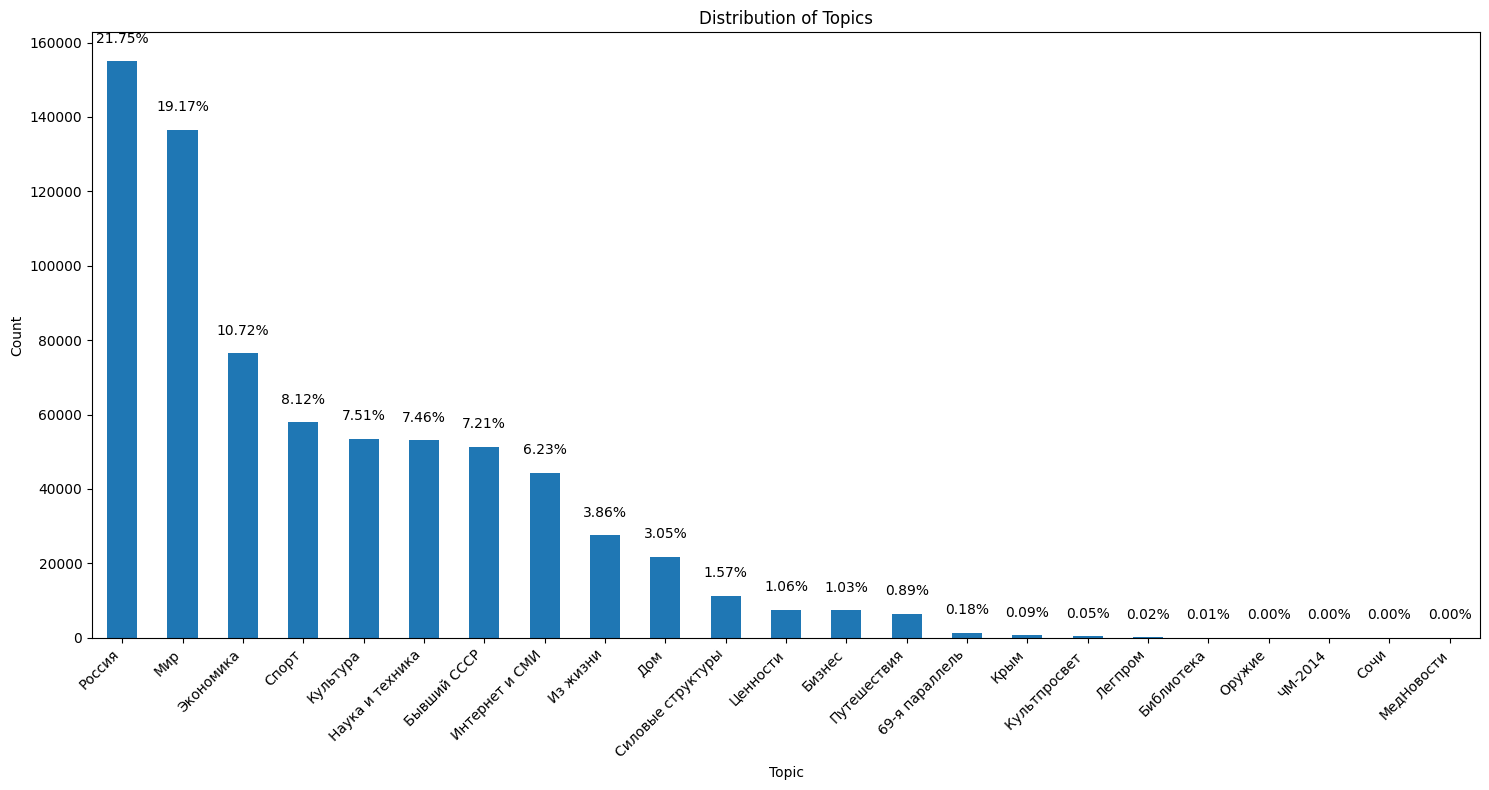

In [10]:
topic_counts = df['topic'].value_counts()

plt.figure(figsize=(15, 8))
ax = topic_counts.plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

total = topic_counts.sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 5000,
            '{:1.2f}%'.format(100*height/total),
            ha="center")

plt.tight_layout()
plt.show()

Average text length: 1333.5047624794079


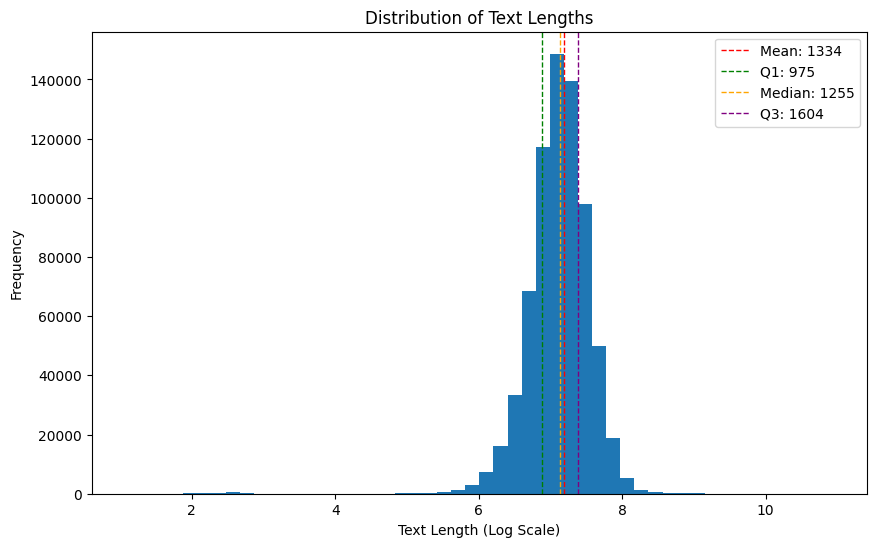

In [11]:
df['text_length'] = df['text'].str.len().astype(int)
average_text_length = df['text_length'].mean()
print(f"Average text length: {average_text_length}")

plt.figure(figsize=(10, 6))
plt.hist(np.log(df['text_length']), bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (Log Scale)')
plt.ylabel('Frequency')

mean_len = df['text_length'].mean()
q1_len, median_len, q3_len = np.percentile(df['text_length'], [25, 50, 75])

plt.axvline(np.log(mean_len), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.0f}')
plt.axvline(np.log(q1_len), color='g', linestyle='dashed', linewidth=1, label=f'Q1: {q1_len:.0f}')
plt.axvline(np.log(median_len), color='orange', linestyle='dashed', linewidth=1, label=f'Median: {median_len:.0f}')
plt.axvline(np.log(q3_len), color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_len:.0f}')

plt.legend()
plt.show()

Without applying a logarithmic transformation to the feature, the plot becomes hard to interpret

In [12]:
stop_words = set(stopwords.words('russian') + list(punctuation + '«»'))
morph = MorphAnalyzer()

def tokenize_sentence(text):
    tokens = word_tokenize(text.lower())
    lemmas = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if token not in stop_words
    ]
    return ' '.join(lemmas)

In [13]:
df_text_topic_sample = df[['text', 'topic']].sample(50_000, random_state=19)

In [14]:
df_preprocessed_text = df_text_topic_sample['text'].apply(tokenize_sentence)

In [15]:
vectorize = TfidfVectorizer()
tfidf_text = vectorize.fit_transform(df_preprocessed_text)

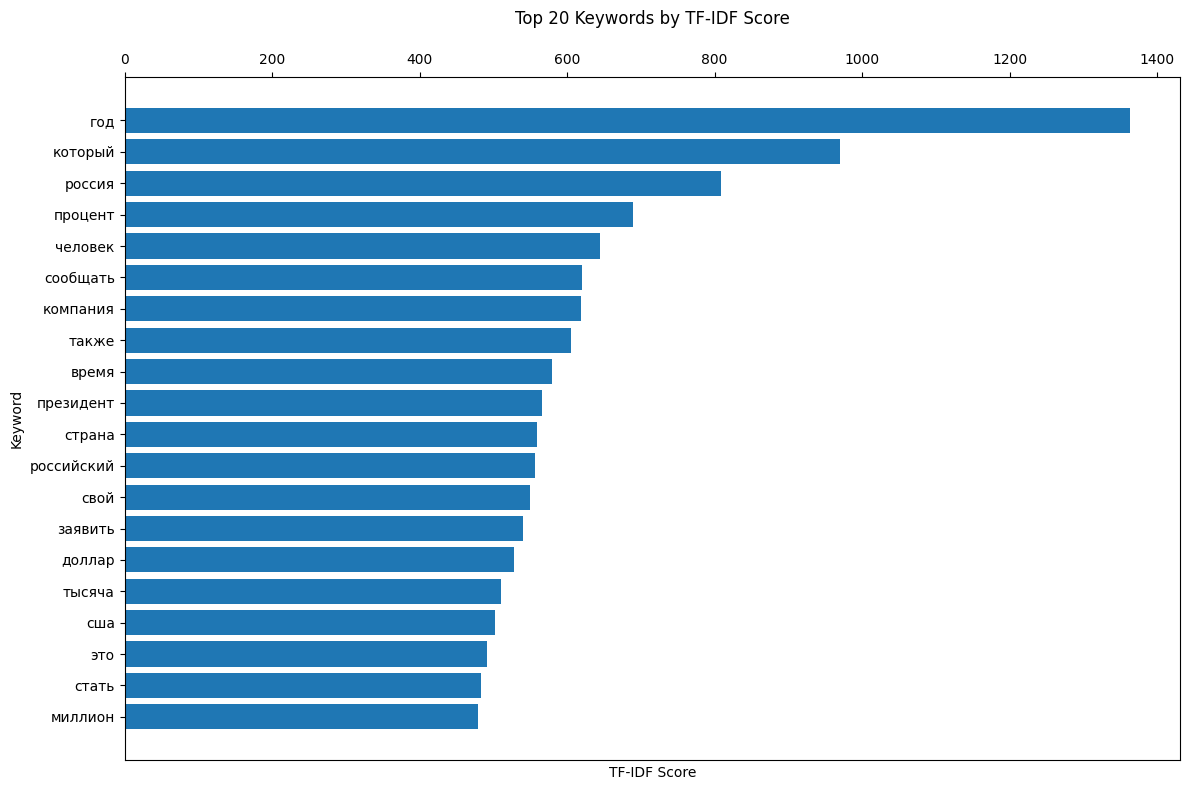

In [16]:
feature_names = vectorize.get_feature_names_out()
overall_tfidf_scores = tfidf_text.sum(axis=0)

overall_keyword_scores = pd.DataFrame({'keyword': feature_names, 'tfidf_score': overall_tfidf_scores.tolist()[0]})
overall_keyword_scores = overall_keyword_scores.sort_values(by='tfidf_score', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(overall_keyword_scores['keyword'][:20], overall_keyword_scores['tfidf_score'][:20])
plt.title('Top 20 Keywords by TF-IDF Score\n')
plt.ylabel('Keyword')
plt.xlabel('TF-IDF Score')
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
major_topics = df_text_topic_sample['topic'].value_counts()[:'Путешествия'].index
df_text_topic_sample.loc[~df_text_topic_sample['topic'].isin(major_topics), 'topic'] = 'Прочее'

In [18]:
le = LabelEncoder()
df_text_topic_sample['topic'] = le.fit_transform(df_text_topic_sample['topic'])

In [19]:
x = tfidf_text
y = df_text_topic_sample['topic']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=19)

# Models

## LinearSVC

In [21]:
svc_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

svc = LinearSVC(class_weight='balanced', random_state=19, dual=False)

svc_grid = GridSearchCV(svc, svc_param_grid, scoring="f1_macro", cv=5)

svc_grid.fit(x_train, y_train)

print("Best parameters: ", svc_grid.best_params_)
print("Best cross-validation score: ", svc_grid.best_score_)

best_svc_model = svc_grid.best_estimator_

Best parameters:  {'C': 1}
Best cross-validation score:  0.7414755394192728


In [22]:
svc_pred = best_svc_model.predict(x_test)

In [23]:
# # Best parameters:  {'C': 1}
# svc_grid = LinearSVC(class_weight='balanced', random_state=19, dual=False)
# svc_grid.fit(x_train, y_train)
# svc_pred = svc_grid.predict(x_test)

In [24]:
f1_score(y_test, svc_pred, average='macro')

0.7409601068247319

## LogisticRegression

In [25]:
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

lr = LogisticRegression(class_weight='balanced')

lr_grid = GridSearchCV(lr, lr_param_grid, scoring="f1_macro", cv=5)

lr_grid.fit(x_train, y_train)

print("Best parameters: ", lr_grid.best_params_)
print("Best cross-validation score: ", lr_grid.best_score_)

best_lr_model = lr_grid.best_estimator_

Best parameters:  {'C': 10, 'penalty': 'l2'}
Best cross-validation score:  0.7446868778811783


In [26]:
lr_pred = best_lr_model.predict(x_test)

In [27]:
# # Best parameters:  {'C': 10, 'penalty': 'l2'}
# lr_grid = LogisticRegression(class_weight='balanced', **{'C': 10, 'penalty': 'l2'})
# lr_grid.fit(x_train, y_train)
# lr_pred = lr_grid.predict(x_test)

In [28]:
f1_score(y_test, lr_pred, average='macro')

0.7507613173123358

## RandomForestClassifier

In [29]:
rfc_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier(random_state=19)

rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv=3, n_jobs=-1, scoring="f1_macro", verbose=2)

rfc_grid.fit(x_train, y_train)

print("Best parameters: ", rfc_grid.best_params_)
print("Best cross-validation score: ", rfc_grid.best_score_)

best_rfc_model = rfc_grid.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  55.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  44.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.4min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  27.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  25.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  25.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  26.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.1min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.5min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  28.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.0min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  28.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.5min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  30.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.5min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  14.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  28.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  47.3s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  44.5s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  44.3s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  28.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  25.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  42.2s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.7min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  13.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  59.5s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  58.5s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.2min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  28.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  25.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  42.8s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.8min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.1min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.3min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  38.6s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  50.0s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.9min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  41.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.7min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.2min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  27.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  25.7s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  44.2s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.9min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  41.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.9min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  40.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.0min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  39.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  28.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  51.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  26.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  54.2s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  38.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.7min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  29.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  50.5s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  56.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  39.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.1min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  13.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  37.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.9min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  27.6s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  54.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  38.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  29.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  52.6s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  37.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  40.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  37.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.0min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  40.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  52.6s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  27.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  40.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.3min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  14.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  28.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.6min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  13.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  30.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  52.6s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  29.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.6min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 7.3min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  30.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 7.3min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  24.7s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.8min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  25.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.1min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  43.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.1min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  58.8s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 1.9min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  26.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 2.7min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  38.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  48.8s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.0min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  25.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 2.9min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  40.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  52.0s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.1min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  43.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.8min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  40.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  38.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  48.3s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.3min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  25.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  26.3s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.5min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  13.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  55.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  41.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 3.1min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.3min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  37.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.3min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  28.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  49.6s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.3min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  25.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.3min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  27.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.3min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  40.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.6min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  29.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  51.6s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.0min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  42.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  48.4s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  36.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.2min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  26.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  53.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.2min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  14.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  29.7s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  46.0s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  37.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.2min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  39.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.5min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  40.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.0min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  40.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  51.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  35.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.3min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.8min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.3s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.8min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.9min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  13.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  28.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.4min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  40.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.2min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  13.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  30.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  43.7s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.1min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.1min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.7min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  26.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  26.9s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  39.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  59.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.3min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  25.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  26.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  25.3s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.8min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  26.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  53.0s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.4min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  27.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  51.4s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.7min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  25.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.8min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.4min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  42.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.6min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 4.1min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.9min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 4.7min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  39.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 4.9min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  41.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 5.1min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  26.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.8min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 6.1min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  13.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 6.4min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 6.5min


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 6.8min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  39.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 7.2min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  25.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 7.2min


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 8.8min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 9.0min


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  39.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 9.2min


Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score:  0.5029446757585078


In [30]:
rfc_pred = best_rfc_model.predict(x_test)

In [31]:
# # Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
# rfc_grid = RandomForestClassifier(class_weight='balanced', random_state=19, **{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300})
# rfc_grid.fit(x_train, y_train)
# rfc_pred = rfc_grid.predict(x_test)

In [32]:
f1_score(y_test, rfc_pred, average='macro')

0.5139982433680629

## KNeighborsClassifier

In [33]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, knn_param_grid, cv=3, n_jobs=-1, scoring="f1_macro", verbose=2)

knn_grid.fit(x_train, y_train)

print("Best parameters: ", knn_grid.best_params_)
print("Best cross-validation score: ", knn_grid.best_score_)

best_knn_model = knn_grid.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


Best parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 7, 'p': 1}
Best cross-validation score:  0.6205056532739737


In [34]:
knn_pred = best_knn_model.predict(x_test)

In [35]:
# # Best parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 7, 'p': 1}
# knn_grid = KNeighborsClassifier(**{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 7, 'p': 1})
# knn_grid.fit(x_train, y_train)
# knn_pred = knn_grid.predict(x_test)

In [36]:
f1_score(y_test, knn_pred, average='macro')

0.6269082453239714